# A notebook for pileup study

In [1]:
import ROOT
f = ROOT.TFile('PileupAnalyzer.root')
folder_name = 'pileupAnalyzer'
c = ROOT.TCanvas('canv', 'canv', 600, 400)
leg = ROOT.TLegend(0.7,0.7,0.9,0.9)
ROOT.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.08/04


# 1. First part is for sanity check

Here we are looking at the energy of the decay positron, energy of the gamma from radiative decay and the energy deposition

In [2]:
ePrimary = f.Get('{}/ePrimary'.format(folder_name))
eGammaPrimary = f.Get('{}/eGammaPrimary'.format(folder_name))
eDep = f.Get('{}/eDep'.format(folder_name))
tree = f.Get('{}/tree'.format(folder_name))

In [3]:
def draw_both():
    ePrimary.Draw()
    eGammaPrimary.Draw("sames")
    eDep.Draw("sames")
    c.Draw()

In [4]:
def set_style():
    ePrimary.SetLineColor(1)
    eGammaPrimary.SetLineColor(2)
    eDep.SetLineColor(4)

In [5]:
def draw_legend():
    leg.AddEntry(ePrimary,ePrimary.GetName(),"l")
    leg.AddEntry(eGammaPrimary,eGammaPrimary.GetName(),"l")
    leg.AddEntry(eDep,eDep.GetName(),"l")
    leg.Draw()

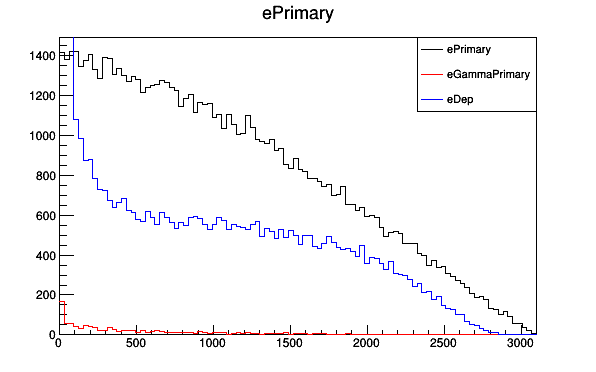

In [6]:
set_style()
draw_both()
draw_legend()

# 2. Now let's try to use pandas to analyze our data for pileup

In [7]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 8 # sets default plot size

In [8]:
data_rows = []
for entry in tree:
    data_rows.append([entry.eTruth, entry.eDep, entry.timeTruth,
                                          entry.timeHit, entry.caloNum])
# create the analysis DataFrame
df = pd.DataFrame(data_rows, columns=['e_truth', 'e_dep', 'time_truth', 'time_hit', 'calo_num'])
df.head()

,e_truth,e_dep,time_truth,time_hit,calo_num
0,233.450529,220.973088,2597.835227,2599.191650,1
1,1105.812331,288.984265,8286.316566,8306.015625,21
2,827.560053,796.611667,9322.758446,9326.403320,2
3,277.998508,0.000000,5326.117760,-1.000000,-1
4,131.867443,0.000000,70378.807908,-1.000000,-1


## Let's look at the histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122283f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12523cb90>]], dtype=object)

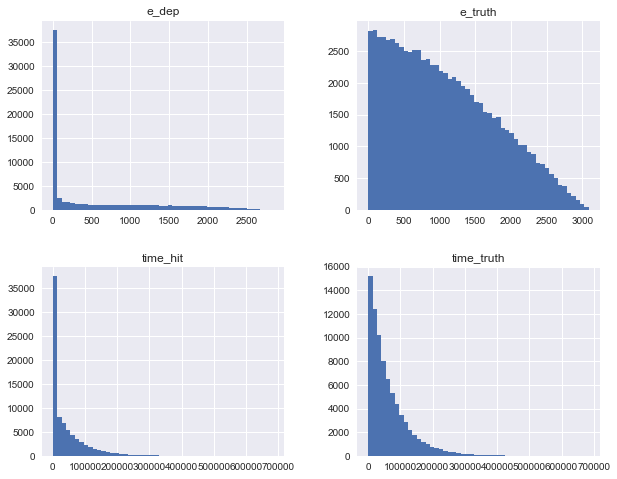

In [9]:
df.hist(['e_truth','e_dep','time_truth','time_hit'],bins=50)

## 2.1 remove events with no hits and sort the rest according to calo_num and time_truth

In [10]:
df = df[df.calo_num>-1]
series=df.groupby(['time_truth']).mean()
series.head(15)

,e_truth,e_dep,time_hit,calo_num
time_truth,,,,
18.928585,544.179231,523.872094,21.664135,1
25.730252,767.474814,229.575367,53.260315,4
49.433663,666.124374,628.990254,51.798515,6
51.456642,563.004437,1.044049,55.900242,7
67.520473,1259.615167,1119.586426,75.755302,9
68.122807,331.173368,297.931112,69.941299,7
71.257784,428.739894,1.475145,75.576500,8
77.033643,1467.577987,23.391676,97.857872,7
79.062586,126.060286,3.463693,82.123634,1


## 2.2 Add another column showing the dt between this event and the event before

In [11]:
series["dt"] = series['time_hit'].diff(1)
series.head(15)

,e_truth,e_dep,time_hit,calo_num,dt
time_truth,,,,,
18.928585,544.179231,523.872094,21.664135,1,NaN
25.730252,767.474814,229.575367,53.260315,4,31.596180
49.433663,666.124374,628.990254,51.798515,6,-1.461800
51.456642,563.004437,1.044049,55.900242,7,4.101727
67.520473,1259.615167,1119.586426,75.755302,9,19.855061
68.122807,331.173368,297.931112,69.941299,7,-5.814003
71.257784,428.739894,1.475145,75.576500,8,5.635201
77.033643,1467.577987,23.391676,97.857872,7,22.281372
79.062586,126.060286,3.463693,82.123634,1,-15.734238


## 2.3 Let's look at only calo 00

In [12]:
real_hit = df[df.calo_num==0]
real_hit=df.groupby(['calo_num','time_truth']).mean()
real_hit["dt"] = real_hit['time_hit'].diff(1)
real_hit.head(15)

e_truth        e_dep    time_hit          dt
calo_num time_truth                                                  
0        115.871234   293.399686   125.575507  118.182472         NaN
         122.548781   858.783237   769.521276  126.320602    8.138130
         186.342021  1436.879928  1325.108935  190.300842   63.980240
         188.854145   791.989991   763.625368  192.108627    1.807785
         190.213433   434.357860   414.831847  191.589844   -0.518784
         195.316774  1053.989131   274.225989  214.105499   22.515656
         208.369221  1119.362785   617.859847  217.130219    3.024719
         218.663106   555.463273   536.268886  221.481232    4.351013
         250.116720   139.261601     2.107877  298.500061   77.018829
         263.774723   267.584581    71.072469  264.932587  -33.567474
         367.221200  1502.784934   190.877988  375.791779  110.859192
         371.630884   538.717158     0.144824  378.135406    2.343628
         402.109499  1250.698656     0.110138  408.305115   30.169708
         416.852038  1514.718734   327.184316  420.642883   12.337769
         474.953660  1377.421295   925.062814  479.675873   59.032990

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12226ef50>]], dtype=object)

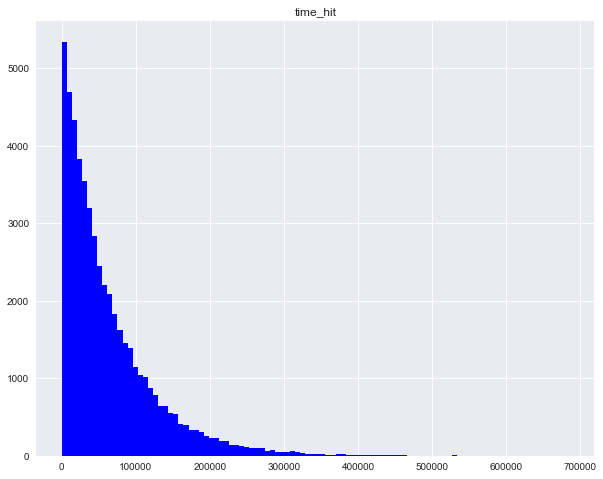

In [13]:
real_hit.hist('time_hit',bins=100,color='blue')

In [14]:
pileup_hit = real_hit[real_hit.dt>5 ]
pileup_hit.head(10)

e_truth        e_dep    time_hit          dt
calo_num time_truth                                                  
0        122.548781   858.783237   769.521276  126.320602    8.138130
         186.342021  1436.879928  1325.108935  190.300842   63.980240
         195.316774  1053.989131   274.225989  214.105499   22.515656
         250.116720   139.261601     2.107877  298.500061   77.018829
         367.221200  1502.784934   190.877988  375.791779  110.859192
         402.109499  1250.698656     0.110138  408.305115   30.169708
         416.852038  1514.718734   327.184316  420.642883   12.337769
         474.953660  1377.421295   925.062814  479.675873   59.032990
         495.517746  2361.563529  2118.554717  504.449921   24.774048
         510.784073   838.020485   578.118517  514.901367   10.959595

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126c01250>]], dtype=object)

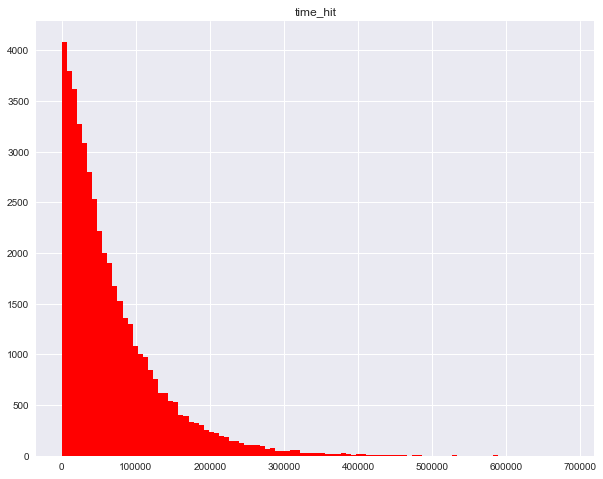

In [15]:
pileup_hit.hist('time_hit',bins=100,color='red')

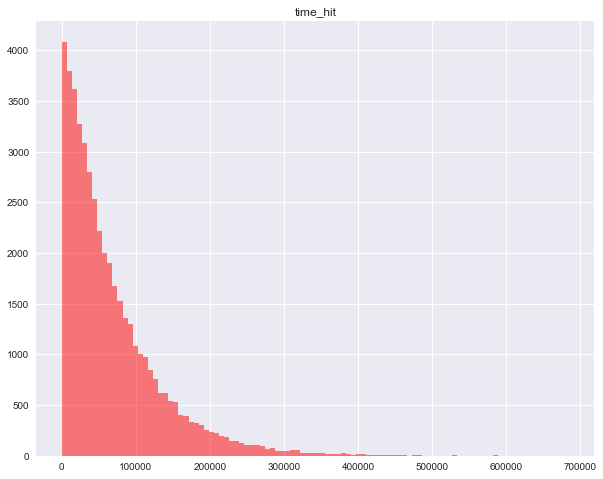

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Counts')
ax.set_xlabel('Times [ns]')
real_hit.hist('time_hit',ax=ax,bins=100,color='blue',alpha=0.5)
pileup_hit.hist('time_hit',ax=ax,bins=100,color='red',alpha=0.5)
plt.show()